In [150]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [151]:
# Load data
df = pd.read_excel('data.xlsx', sheet_name='Rekapan')

In [152]:
# Muncul data awal
df.head()

,Tanggal,Nama Customer,Lokasi Customer,Nama Produk,Type Produk,SO,TERKIRIM,SISA PO,INTERNAL,EKSTERNAL,Harga Komoditas Bijih Besi,Indeks Produksi Dalam Negeri,Data Inflasi,Kurs
0,2018-01-01,TOA GALVA INDUSTRIES,"-6.398580325820022, 106.8648544138663",FIXING SCREW,Accessories,31500.0,31500.0,0,-,-,75.86,142,0.0325,13413
1,2018-01-01,TOA GALVA INDUSTRIES,"-6.398580325820022, 106.8648544138663",BS-1020 BRACKET,Accessories,14900.0,13600.0,1300,-,-,75.86,142,0.0325,13413
2,2018-01-01,TOA GALVA INDUSTRIES,"-6.398580325820022, 106.8648544138663",HX-SW HANDLE BRACKET,Accessories,250.0,250.0,0,-,-,75.86,142,0.0325,13413
3,2018-01-01,TOA GALVA INDUSTRIES,"-6.398580325820022, 106.8648544138663",TC-303 ANGLE,Accessories,29000.0,16390.0,12610,-,-,75.86,142,0.0325,13413
4,2018-01-01,TOA GALVA INDUSTRIES,"-6.398580325820022, 106.8648544138663",TC-615 ANGLE,Accessories,1650.0,1650.0,0,-,-,75.86,142,0.0325,13413


In [153]:
# Muncul data akhir
df.tail()

,Tanggal,Nama Customer,Lokasi Customer,Nama Produk,Type Produk,SO,TERKIRIM,SISA PO,INTERNAL,EKSTERNAL,Harga Komoditas Bijih Besi,Indeks Produksi Dalam Negeri,Data Inflasi,Kurs
19675,2024-04-01,HI-LEX,"-6.162553545608601, 106.64868720941404",PIPA TIEROD 28X1070 M20,OEM,245.0,245.0,0,-,-,110.91,-,0.03,16276
19676,2024-04-01,HI-LEX,"-6.162553545608601, 106.64868720941404",ANCHOR PANTHER TBR52 AS19,OEM,503.0,503.0,0,-,-,110.91,-,0.03,16276
19677,2024-04-01,HI-LEX,"-6.162553545608601, 106.64868720941404",MANIPOL TITIK ( DRAT HALUS DAN KASAR),OEM,5233.0,5233.0,0,-,-,110.91,-,0.03,16276
19678,2024-04-01,HI-LEX,"-6.162553545608601, 106.64868720941404",AS TIEROD 28 X 1030 M22,OEM,15.0,15.0,0,-,-,110.91,-,0.03,16276
19679,2024-04-01,MUARATEWEH SPRING,"-6.200093920369392, 106.91619012788578",KUNCI BUSI 170,OEM,1654.0,1654.0,0,-,-,110.91,-,0.03,16276


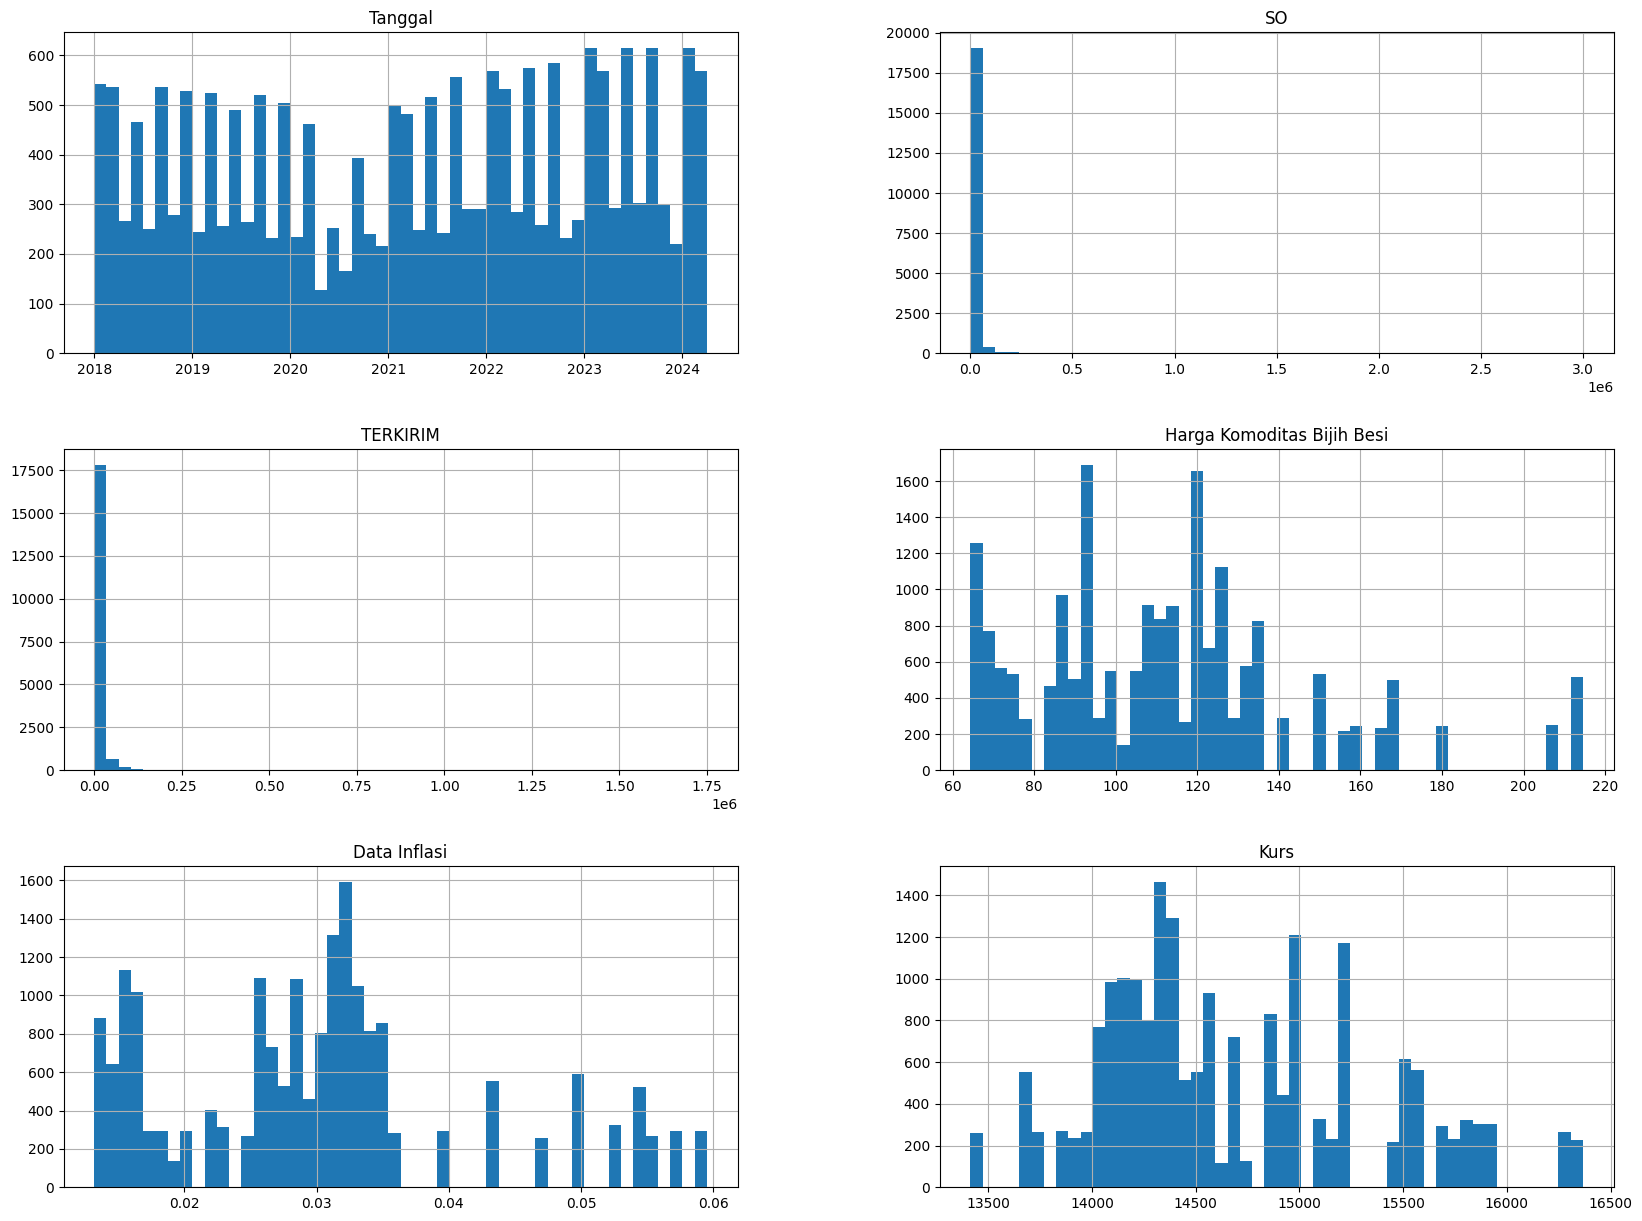

In [154]:
# Statistik deskriptif dasar
df.describe()

# Cek nilai yang hilang
df.isnull().sum()

# Visualisasi distribusi data
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [155]:
# Filter kolom terkait
data_filtered = df[['Tanggal', 'SO', 'TERKIRIM', 'Harga Komoditas Bijih Besi', 'Indeks Produksi Dalam Negeri', 'Data Inflasi', 'Kurs']]

# Ganti nama kolom
data_filtered.columns = ['Tanggal', 'SO', 'Terkirim', 'Harga Komoditas', 'Indeks Produksi', 'Data Inflasi', 'Kurs']

# Konversi tipe data
data_filtered['Tanggal'] = pd.to_datetime(data_filtered['Tanggal'])

# Ganti tipe data 'Indeks Produksi'
data_filtered['Indeks Produksi'] = pd.to_numeric(data_filtered['Indeks Produksi'], errors='coerce')

# Buat kolom 'Year' dan 'Month'
# data_filtered['Year'] = data_filtered['Tanggal'].dt.year
# data_filtered['Month'] = data_filtered['Tanggal'].dt.month

data_filtered['bulan_tahun'] = data_filtered['Tanggal'].dt.to_period('M')

C:\Users\chris\AppData\Local\Temp\ipykernel_16476\2528436215.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Tanggal'] = pd.to_datetime(data_filtered['Tanggal'])
C:\Users\chris\AppData\Local\Temp\ipykernel_16476\2528436215.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Indeks Produksi'] = pd.to_numeric(data_filtered['Indeks Produksi'], errors='coerce')
C:\Users\chris\AppData\Local\Temp\ipykernel_16476\2528436215.py:17: SettingWithCopyWarning: 
A value is trying to be 

In [156]:
# Rekapan Bulanan
# monthly_summary = data_filtered.groupby(['Year', 'Month']).agg({
#     'SO': 'sum',
#     # 'Terkirim': 'sum',
#     # 'Harga Komoditas': 'mean',
#     # 'Indeks Produksi': 'mean',
#     # 'Data Inflasi': 'mean',
#     # 'Kurs': 'mean'
# }).reset_index()

monthly_summary = data_filtered.groupby('bulan_tahun').agg({
    'SO': 'sum',
    # Uncomment other columns as needed
    # 'Terkirim': 'sum',
    # 'Harga Komoditas': 'mean',
    # 'Indeks Produksi': 'mean',
    # 'Data Inflasi': 'mean',
    # 'Kurs': 'mean'
}).reset_index()

# Muncul Rekapan Bulanan
monthly_summary

,bulan_tahun,SO
0,2018-01,2845126.0
1,2018-02,2751060.0
2,2018-03,3751325.0
3,2018-04,3350350.0
4,2018-05,2733224.0
...,...,...
71,2023-12,2022755.0
72,2024-01,2847896.0
73,2024-02,2730829.0
74,2024-03,2765759.0


In [157]:
# Set alpha value for SES
alpha = 0.1

# Initialize columns for SES forecast and error metrics
monthly_summary['ses_forecast'] = np.nan
monthly_summary['Error'] = np.nan
monthly_summary['MAD'] = np.nan
monthly_summary['MSE'] = np.nan
monthly_summary['MAPE'] = np.nan

# Set initial forecast to the first SO value
monthly_summary.loc[0, 'ses_forecast'] = monthly_summary.loc[0, 'SO']

# Apply SES formula and calculate error metrics for each subsequent row
for i in range(1, len(monthly_summary)):
    # SES Forecast
    monthly_summary.loc[i, 'ses_forecast'] = (alpha * monthly_summary.loc[i-1, 'SO']) + ((1 - alpha) * monthly_summary.loc[i-1, 'ses_forecast'])
    
    # Error
    monthly_summary.loc[i, 'Error'] = monthly_summary.loc[i, 'SO'] - monthly_summary.loc[i, 'ses_forecast']
    
    # MAD (Mean Absolute Deviation)
    monthly_summary.loc[i, 'MAD'] = abs(monthly_summary.loc[i, 'Error'])
    
    # MSE (Mean Squared Error)
    monthly_summary.loc[i, 'MSE'] = monthly_summary.loc[i, 'Error'] ** 2
    
    # MAPE (Mean Absolute Percentage Error)
    if monthly_summary.loc[i, 'SO'] != 0:
        monthly_summary.loc[i, 'MAPE'] = (abs(monthly_summary.loc[i, 'Error']) / monthly_summary.loc[i, 'SO']) * 100
    else:
        monthly_summary.loc[i, 'MAPE'] = np.nan

# Show the result
print(monthly_summary)

   bulan_tahun         SO  ses_forecast          Error            MAD  \
0      2018-01  2845126.0  2.845126e+06            NaN            NaN   
1      2018-02  2751060.0  2.845126e+06  -94066.000000   94066.000000   
2      2018-03  3751325.0  2.835719e+06  915605.600000  915605.600000   
3      2018-04  3350350.0  2.927280e+06  423070.040000  423070.040000   
4      2018-05  2733224.0  2.969587e+06 -236362.964000  236362.964000   
..         ...        ...           ...            ...            ...   
71     2023-12  2022755.0  2.757022e+06 -734267.452027  734267.452027   
72     2024-01  2847896.0  2.683596e+06  164300.293175  164300.293175   
73     2024-02  2730829.0  2.700026e+06   30803.263858   30803.263858   
74     2024-03  2765759.0  2.703106e+06   62652.937472   62652.937472   
75     2024-04  2020844.0  2.709371e+06 -688527.356275  688527.356275   

             MSE       MAPE  
0            NaN        NaN  
1   8.848412e+09   3.419264  
2   8.383336e+11  24.407525  
3  

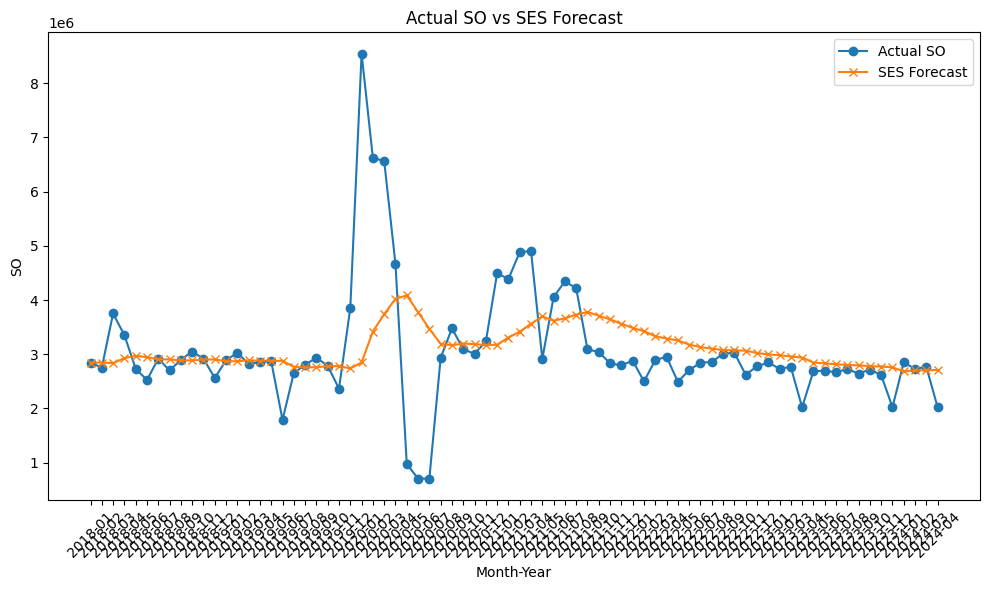

In [158]:
# Optional: Plot the actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(monthly_summary['bulan_tahun'].astype(str), monthly_summary['SO'], label='Actual SO', marker='o')
plt.plot(monthly_summary['bulan_tahun'].astype(str), monthly_summary['ses_forecast'], label='SES Forecast', marker='x')
plt.xlabel('Month-Year')
plt.ylabel('SO')
plt.xticks(rotation=45)
plt.title('Actual SO vs SES Forecast')
plt.legend()
plt.tight_layout()
plt.show()